# Partial History Wang Buzsaki


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
from scipy import stats
import matplotlib.lines as lines
import matplotlib as mpl

sys.path.insert(1, "../utils/")
import WB, Stimuli

from neuron import h
h.load_file("stdrun.hoc")
from neuron.units import mV, ms

In [69]:
ns = list(range(5,20,2))
num_input_patterns_per_n = 100
num_histories = 1000

excitatory_interval = 5
inhibitory_interval = 15

## Generate stimuli

In [70]:
stimuli = {}

for n in ns:
    stimuli[n] = {}
    for pattern_ind in range(num_input_patterns_per_n):
        stimuli[n][pattern_ind] = Stimuli.excitatory_and_inhibitory_n(excitatory_interval, inhibitory_interval, n)

## Generate histories

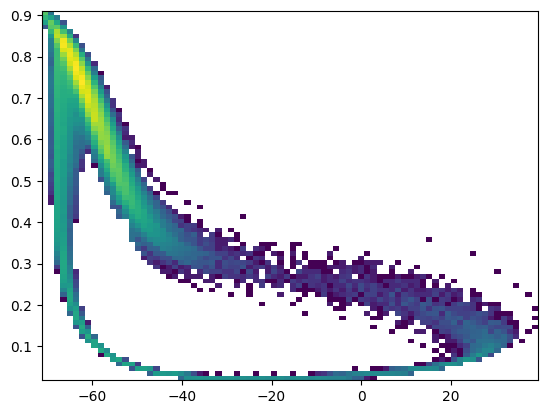

In [71]:
# generate histories
histories_sim_duration = 10000
stim_params = Stimuli.ExperimentalStimParams()

df, spikes, stims = WB.run_poisson_sim(
    [stim_params.stim_scaffold['wb']['ex'], stim_params.stim_scaffold['wb']['in']], histories_sim_duration)

plt.hist2d(df['v'], df['h'],bins=80, cmin=1, norm=mpl.colors.LogNorm())
plt.show()

In [72]:
history_inds = np.random.randint(250, (histories_sim_duration*40)-250, num_histories)
histories_wb = np.array(
    [
        [df['v'][history_ind] for history_ind in history_inds],
        [df['m'][history_ind] for history_ind in history_inds],
        [df['h'][history_ind] for history_ind in history_inds],
    ]
)
histories_wb.shape

(3, 1000)

## Run experiment

In [73]:
results = {}

# stim scaffolds
estims = stim_params.stim_scaffold['wb']['ex']
istims = stim_params.stim_scaffold['wb']['in']

for n in ns:
    print(f'n = {n}')
    results[n] = {}
    print('______PROGRESS______')
    progress = 0.0
    for pattern_ind in range(num_input_patterns_per_n):
        stim_duration = max([t for stim_type, t in stimuli[n][pattern_ind]])  # total duration of the stimuli
        
        estims.stim_times = [stim[1] for stim in stimuli[n][pattern_ind] if stim[0] == 'e']
        istims.stim_times = [stim[1] for stim in stimuli[n][pattern_ind] if stim[0] == 'i']
        
        cells = {}
        fInitializeHandlers = []

        for history_ind in range(num_histories):
            history = histories_wb[:, history_ind]
            
            cells[history_ind] = WB.WB()
            cells[history_ind].add_custom_stimulus(estims)
            cells[history_ind].add_custom_stimulus(istims)
            cells[history_ind].sim_init(v0=history[0], m0=history[1], h0=history[2])
            
            fInitializeHandlers.append(h.FInitializeHandler(cells[history_ind].do_sim_init))

        h.finitialize()
        h.continuerun(stim_duration + 20)
        
        results[n][pattern_ind] = []
        for history_ind in range(num_histories):
            nsts = [spike - stim_duration for spike in list(cells[history_ind].spike_times)]
            nsts = [nst for nst in nsts if nst > 0]
            if len(nsts) < 1:
                results[n][pattern_ind].append(np.nan)
            else:
                results[n][pattern_ind].append(min(nsts))
                
        if progress < pattern_ind / num_input_patterns_per_n:
            progress += 0.05
            print('=',end='')
    print()

<<<<<5>>>>>
<<<<<7>>>>>
<<<<<9>>>>>
<<<<<11>>>>>
<<<<<13>>>>>
<<<<<15>>>>>
<<<<<17>>>>>
<<<<<19>>>>>


## Analysis

In [74]:
def calc_spike_presence_prediction_acc(df):
    no_spike = np.sum(np.isnan(df))
    spike = df.shape[0] - no_spike
    return (no_spike/df.shape[0])**2 + (spike/df.shape[0])**2

def calc_nst_std(df):
    return np.std(df[~np.isnan(df)])

def calc_nst_mae(df):
    _df = df[~np.isnan(df)]
    return np.nanmean(np.abs(_df - np.mean(_df)))

In [75]:
spike_presence_prediction_accs = {n:[] for n in ns}
nst_stds = {n:[] for n in ns}
nst_maes = {n:[] for n in ns}


for n in ns:
    for pattern_ind in range(num_input_patterns_per_n):
        df = np.array(results[n][pattern_ind])
        spike_presence_prediction_accs[n].append(calc_spike_presence_prediction_acc(df))
        nst_stds[n].append(calc_nst_std(df))
        nst_maes[n].append(calc_nst_mae(df))

/tmp/ipykernel_252000/1350620721.py:11: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.abs(_df - np.mean(_df)))


In [76]:
spike_presence_prediction_acc_means = []
nst_std_means = []
nst_mae_means = []

for n in ns:
    spike_presence_prediction_acc_means.append(np.mean(spike_presence_prediction_accs[n]))

    nst_std_means.append(np.nanmean(nst_stds[n]))

    nst_mae_means.append(np.nanmean(nst_maes[n]))

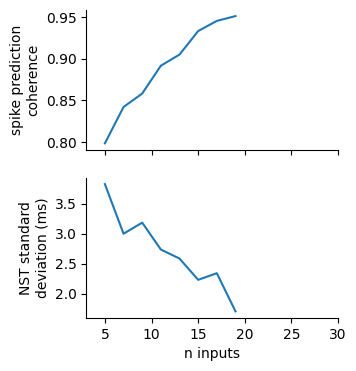

In [78]:
fig, axes = plt.subplots(2,1, figsize=(3.25,4), sharex=True)

axes[0].plot(ns, spike_presence_prediction_acc_means)

axes[1].plot(ns, nst_std_means)

axes[-1].set_xlim(3,30)

axes[0].set_ylabel('spike prediction\ncoherence')
axes[1].set_ylabel('NST standard\ndeviation (ms)')
axes[1].set_xlabel('n inputs')

axes[0].spines['top'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['right'].set_visible(False)

savefig = False
if savefig:
    plt.savefig(f'{figures_dir}spike_prediction_and_nst_std.svg', format='svg')
#plt.savefig(f'{figures_dir}spike_prediction_and_nst_std.png', format='png', dpi=300)

plt.show()